In [1]:
import torch
from torch import Tensor
from torch.utils import data
from torch import nn
import pytorch_lightning as pl
from torch import functional as F
# Defining Sinusoidal Sequence

sequence = torch.sin(torch.arange(0, 2, step=0.001))

class SinusoidalData(data.Dataset):
    def __init__(self, start, end, count, smpl_len, pred_offset):
        super().__init__()
        self.smpl_len = smpl_len
        self.pred_offset = pred_offset
        self.sequence = torch.sin(torch.arange(start, end, step=(end - start) / count))
        
    def __len__(self):
        return self.sequence.shape[0] - (self.smpl_len + self.pred_offset)
    
    def __getitem__(self, index):
        assert(index < self.__len__())
        X, y = self.sequence[index:index + self.smpl_len], self.sequence[index + self.smpl_len + self.pred_offset - 1]
        return (X, y.unsqueeze(0))
        
        
    
class FFN(pl.LightningModule):
    def __init__(self, n_steps, lr=1e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(nn.Linear(n_steps, n_steps * 2), nn.ReLU(),
                                   nn.Linear(n_steps * 2, n_steps * 2), nn.ReLU(),
                                   nn.Linear(n_steps * 2, 1))
        self.lr = lr
        self.loss = nn.MSELoss()
        
    def forward(self, X):
        return self.model(X)
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.model(X)
        assert(isinstance(y_hat, torch.Tensor))
        assert(isinstance(y, torch.Tensor))
        assert(isinstance(self.loss, nn.MSELoss))
        loss = self.loss(y_hat, y)
        if batch_idx % 5 == 0:
            self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.lr)
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.model(X).reshape(y.shape)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss)
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.model(X).reshape(y.shape)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("test_loss", loss)

In [2]:
import math

dataset = SinusoidalData(0, 2 * math.pi, 2000, 10, 1)


In [62]:
import pytorch_lightning as pl
import math
from pytorch_lightning import callbacks
import os

dataset = SinusoidalData(0, 2 * math.pi, 2000, 10, 1)
train_dataset, val_dataset = data.random_split(dataset, [0.9, 0.1])
train_loader = data.DataLoader(train_dataset, batch_size=10, num_workers=os.cpu_count())
val_loader = data.DataLoader(val_dataset, batch_size=10, num_workers=os.cpu_count())
model = FFN(10)


ckpt_callback = callbacks.ModelCheckpoint(dirpath='./model', 
                                          filename='ffn-autoregress-test-{epoch}-{val_loss:.2f}',
                                          monitor='val_loss',
                                          mode='min',
                                          save_top_k=2)

early_stop = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)

trainer = pl.Trainer(accelerator="gpu", callbacks=[ckpt_callback, early_stop], max_epochs=100)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 661   
1 | loss  | MSELoss    | 0     
-------------------------------------
661       Trainable params
0         Non-trainable params
661       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [3]:
from tqdm import tqdm
from matplotlib import pyplot as plt

def predict_k_step(model, data_loader, k_step=1, device=torch.device("cpu")):
    pred = []
    label = []
    for X, y in tqdm(iter(data_loader)):
        assert(isinstance(X, torch.Tensor))
        assert(isinstance(y, torch.Tensor))
        X = X.to(device)
        y = y.to(device)
        model = model.to(device) 
        for i in range(k_step):
            y_hat = model(X)
            X = torch.cat([X, y_hat], dim=1)[:,1:]
        label.append(y)
        pred.append(y_hat)
    pred = torch.cat(pred, dim=1).squeeze(0)
    label = torch.cat(label, dim=1).squeeze(0)
    loss = torch.nn.functional.mse_loss(pred,label)
    return (pred, label, loss)

def draw_timeseries_compare(ts: list[torch.Tensor], labels: list[str], losses: list[torch.Tensor]):
    fig = plt.figure()
    for batch, loss in zip(zip(ts, labels), losses):
        ts, label = batch
        plt.plot(ts.detach().numpy(), label=f"{label} @ {loss}")

    plt.legend()
    plt.show()
        


In [4]:
import pytorch_lightning as pl
import math
from torch.utils import data

n_steps = 10

data_loader = data.DataLoader(dataset)


model = FFN.load_from_checkpoint('./model/ffn-autoregress-test-epoch=99-val_loss=0.00.ckpt')


100%|██████████| 1989/1989 [00:00<00:00, 25165.06it/s]


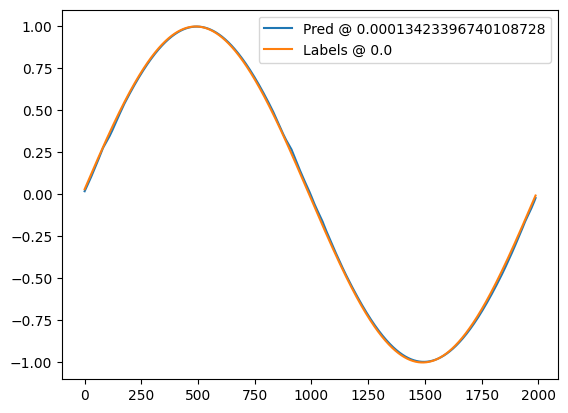

In [5]:
from tqdm import tqdm
pred = []
labels = []
for X, y in tqdm(iter(data_loader)):
    pred.append(model(X))
    labels.append(y)
    
pred = torch.cat(pred, dim=1).squeeze(0)
labels = torch.cat(labels, dim=1).squeeze(0)
loss = torch.nn.functional.mse_loss(pred, labels)

draw_timeseries_compare([pred, labels], ["Pred", "Labels"], [loss, torch.scalar_tensor(0)])



- Step 1 prediction의 결과 거의 0에 수렴하는 mse loss값을 보임
- prediction step을 증가 시킬 때 오차가 얼마나 증가하는지 테스트

100%|██████████| 1989/1989 [00:08<00:00, 230.12it/s]


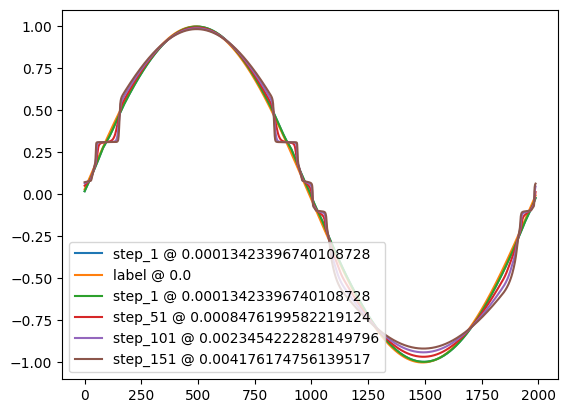

In [6]:

series = []
labels = []
losses = []

pred_k, label, loss = predict_k_step(model, data_loader, 1)
series.append(pred_k)
labels.append("step_1")
series.append(label)
labels.append("label")
losses.append(loss)
losses.append(torch.scalar_tensor(0))

for i in range(1, 200, 50):
    pred, _, loss = predict_k_step(model, data_loader, i)
    labels.append(f"step_{i}")
    series.append(pred)
    losses.append(loss)

    

draw_timeseries_compare(series, labels, losses)




- step 151에서 loss는 0.004로 step 1 대비 약 40배 증가
- 이처럼 step size 증가할 수록 error가 커짐

In [ ]:
import pytorch_lightning as pl
import torch
from torch import nn



class GRUAutoregress(pl.LightningModule):
    def __init__(self, n_steps, lr):
        super().__init__()
        self.lr = lr
        self.model = nn.GRU(n_steps, hidden_size=20, num_layers=2)
        self.loss = nn.MSELoss()
        self.save_hyperparameters()
        
    def forward(self, X):
        y_hat, _h = self.model(X)
        return y_hat
    
    def training_step(self, batch, batch_idx) -> torch.Tensor:
        X, y = batch
        y_hat, _ = self.model(X)
        loss = self.loss(y_hat, y)
        return loss
        
    